In [544]:
CLIENT_ID=*SEE NOTES*
CLIENT_SECRET=*SEE NOTES*

In [51]:
blockbuster = 'spotify:track:5jQYkYhoOlBW4vJ2l4TCxl' # Test track from Run the Jewels

In [69]:
import spotipy
from spotipy import util
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import pandas as pd
import matplotlib.pyplot as plt
import urllib

## REMOVE CLIENT_ID AND CLIENT_SECRET BEFORE PUSHING ##

#CLIENT_ID
#CLIENT_SECRET
USERNAME = 'elw86ve5g5t944wwlef6qyzu3' # Alex Fioto's user id
SCOPE = 'playlist-modify-public user-top-read'
LOCAL_REDIRECT_URI = 'http://127.0.0.1:8080'
REDIRECT_URI = 'https://fioto-spotify-flask.herokuapp.com/'

# Requesting access token
token = util.prompt_for_user_token(username=USERNAME,
                                   scope=SCOPE,
                                   client_id=CLIENT_ID,
                                   client_secret=CLIENT_SECRET,
                                   redirect_uri=LOCAL_REDIRECT_URI) 
# Instantiating OAuth object
sp = spotipy.Spotify(auth=token)

In [5]:
def show_album_art(track_uri):
    '''
    Retrieves and displays album art for a given track on Spotify
    
    Parameters:
    uri: Spotify track URI
    '''
    
    # Getting track object
    track = sp.track(track_uri)
    
    # Extracting image URL 
    url = track['album']['images'][0]['url']
    
    # Creating file object
    f = urllib.request.urlopen(url)
    
    # Creating an matplotlib image read object specifying jpg format
    a = plt.imread(f, format='jpg')
    
    # Turning off axis
    plt.axis(False)
    
    # Showing image
    plt.imshow(a);

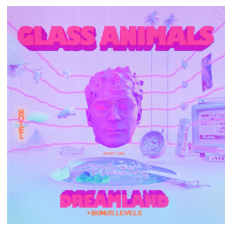

In [6]:
heat_waves = 'spotify:track:0BHStoRqbogddXgezqumz3'
show_album_art(heat_waves)

In [132]:
def spotify_uri_search(search, type='album', limit=10):
    '''
    Search for a Spotify track, album, playlist, show or episode URI. 
    
    Parameters:
    search: search string
    
    type: type of uri. Choose from track, album, playlist, show or episode URI. 
    
    limit: integer limit to return. 0-50
    '''
    # Creating empty results list and results dictionary
    if limit > 50 or limit < 1:
        raise TypeError('Limit needs to be an integer between 1-50')
    results = []
    res_dict = {}

     # Replacing spaces with + 
    q = search.replace(' ', '+')

    # Creating search object
    res = sp.search(q=q, limit=limit, type=type,)

    # Selecting all of the tracks in search object
    tracks = res[type+'s']['items']
    
    # Iterating through tracks or albums 
    for item in tracks:
        # Creating result dictionary entry
        res_dict[item['name']] = item['uri']
        
        # Adding name of track or album along with the artists to results
        results.append(item['name'] + ' BY ' + item['artists'][0]['name'])
    
    # Printing results for user to decide which album
    for i in range(len(results)):
        print(f'{i}: {type}: {results[i]}')
        
    # Requesting user input for correct choice
    response = input('Please select a valid index')
    
    # Selecting appropriate Spotify URI
    uri = res_dict.get(results[int(response)].split(' BY ')[0])
    
    return uri

In [133]:
res = spotify_uri_search('cheese', type='track', limit=30)

0: track: Cheesecake BY Billy Marchiafava
1: track: Cheeseburger In Paradise BY Jimmy Buffett
2: track: cheese BY Bal3an
3: track: Cheeseburger Family BY Jack Stauber's Micropop
4: track: Cheese and Dope BY Project Pat
5: track: Cheese BY Jack Stauber's Micropop
6: track: CHEESE STRINGS BY Yxngxr1
7: track: Cheese & Wine BY DPR LIVE
8: track: Cheese Distortion BY Broke Silence
9: track: Cheese Time BY GBoomer
10: track: Cheese BY Effin
11: track: Cheese BY Pesiepol
12: track: Cheese BY The Floozies
13: track: Cheese is Everywhere: Describing a Night Out BY Aziz Ansari
14: track: Cheesed off BY vensterbank
15: track: Cheese BY Tiago Rosa
16: track: Cheese Wine And Fine BY Poky
17: track: Chucky Cheese BY MadeinTYO
18: track: Cheesesteaks BY Vinnie Paz
19: track: Cheese Angle District BY Flocotronic
20: track: Cheese & Broccoli BY Swift2cali
21: track: Cheese Head BY SL Moon
22: track: Cheese Cheater BY Mr Gamble
23: track: Cheese Is Overrated BY The Alchemist
24: track: Cheese Cake - Re

Please select a valid index 4


In [134]:
res

'spotify:track:2iiCDhPr51If2XCDQJJ0nC'

In [56]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity
import pandas as pd
pd.set_option("display.precision", 14)

In [147]:
def recommend_songs(sp, artists=None, genres=None, tracks=None, limit=100, n_tracks=10, listener_based=True, time_range='medium_term', drop_cols=[]):
    '''
    This function will recommend songs based on a seed artist, seed genres and/or seed tracks.
    The searched songs will be compared to user top tracks and return only those songs with the 
    highest cosine similarity.
   
    Parameters:
    
    drop_cols: columns to drop from numeric featue comparison. Choose from: danceability                                                                         danceability
                                                                            energy
                                                                            key
                                                                            loudness
                                                                            mode
                                                                            speechiness
                                                                            acousticness
                                                                            instrumentalness
                                                                            liveness
                                                                            valence
                                                                            tempo
    '''
    
    # Fetching Spotify recommendations 
    recs = sp.recommendations(seed_artists=artists, seed_genres=genres, seed_tracks=tracks, limit=limit)
    
    # Saving lists of track names and URIs of recommended tracks
    rec_track_names = [track['name'] for track in recs['tracks']]
    uris = [track['uri'] for track in recs['tracks']]
    
    # Creating audio features dataframe of recommended tracks
    rec_df = pd.DataFrame.from_dict(sp.audio_features(uris))
    rec_df['track_name'] = rec_track_names
    rec_df['uri'] = uris
    
    # If not listener based, returning list of URIs for Spotify recommended songs
    if not listener_based:
        return list(rec_df[:n_tracks]['uri'])
    
    else: # If listener based
        
        # Fetching user top tracks
        user_tracks = sp.current_user_top_tracks(limit=n_tracks, time_range=time_range)
        
        # Saving lists of track names and URIs of user top tracks
        user_track_names = [track['name'] for track in user_tracks['items']]
        uris = [track['uri'] for track in user_tracks['items']]
        
        # Creating audio features dataframe of user top_tracks
        user_df = pd.DataFrame.from_dict(sp.audio_features(uris))
        user_df['track_name'] = user_track_names
        user_df['uri'] = uris
        
        # Setting new dataframes of only numeric features to be compared
        rec_df_numeric = rec_df.loc[:, rec_df.columns[:11]]
        user_df_numeric = user_df.loc[:, user_df.columns[:11]]
        
        # If drop_cols, dropping appropriate columns from each numeric dataframe
        if drop_cols:
            rec_df_numeric.drop(drop_cols, inplace=True, axis=1)
            user_df_numeric.drop(drop_cols, inplace=True, axis=1)
              
        
        comps = pairwise_distances(rec_df_numeric, user_df_numeric, metric='cosine')
        comps_df = pd.DataFrame(comps, columns=user_track_names, index=rec_track_names)
        comps_df = 1 - comps_df
        comps_df.drop_duplicates(inplace=True)
        
        song_list = []
    
        for user_track in comps_df.columns:
            max_cosine = comps_df[user_track].max()
            song_name = comps_df[comps_df[user_track] == max_cosine].index[0]
            song_uri = list(rec_df.loc[rec_df['track_name'] == song_name, 'uri'])[0]
            #print(f'{user_track}------ closest to ---------> {song_name}')
            song_list.append((song_name, song_uri))

        uri_list = []
        [uri_list.append(track[1]) for track in song_list if track[1] not in uri_list]
    
    
        return rec_df_numeric

In [148]:
blockbuster = 'spotify:track:5jQYkYhoOlBW4vJ2l4TCxl'
uri_list = recommend_songs(sp, 
                           tracks=[blockbuster],
                           listener_based=True,
                           drop_cols=['danceability'])